In [52]:
# HIDE
import pandas as pd
import numpy as np
np.random.seed(7)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", palette=[sns.color_palette('muted')[i] for i in [0,2]], 
        color_codes=True, context="talk")
from IPython import display
import datetime as dt
%matplotlib inline

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, Lambda
from tensorflow.keras.models import Model

create_gif = False

print(f"sklearn: {sk.__version__}")
print(f"pandas: {pd.__version__}")
print(f"tensorflow: {tf.__version__}")

sklearn: 1.0.2
pandas: 1.4.1
tensorflow: 2.10.0


## Data Cleaning

In [114]:
# Importing data and Preparation of data 
df = pd.read_csv('data/compas-scores-raw.csv')

df['DateOfBirth'] = pd.to_datetime(df['DateOfBirth'])
current_year = dt.datetime.now().year
# Check if the year is greater than the current year minus 100
df['DateOfBirth'] = df['DateOfBirth'].apply(lambda x: x.replace(year=x.year - 100) if x.year > current_year else x)
df['Screening_Date'] = pd.to_datetime(df['Screening_Date'])
df['Age'] = (df['Screening_Date'] - df['DateOfBirth']).astype('<m8[Y]')

df_cleaned = df.dropna(subset=['ScoreText'])
df_cleaned.isnull().sum()
data_types = df_cleaned.dtypes
for column in df_cleaned.columns:
    unique_values = df_cleaned[column].unique()
df_cleaned["Ethnic_Code_Text"].replace({"African-Am": "African-American"}, inplace=True)

columns_to_drop = ['Person_ID','AssessmentID','Case_ID','LastName','FirstName','MiddleName','DateOfBirth','ScaleSet_ID','AssessmentReason','Screening_Date','RecSupervisionLevelText','Scale_ID','RecSupervisionLevel','RawScore','DecileScore','AssessmentType','IsCompleted','IsDeleted']
df = df_cleaned.drop(columns=columns_to_drop)
df.rename(columns = {'Sex_Code_Text':'sex'}, inplace = True)
df.rename(columns = {'Ethnic_Code_Text':'ethnic'},inplace = True) 

# Modify Ethnic and ScoreText column
df['ethnic'] = df['ethnic'].apply(lambda x: 'African-American' if x == 'African-American' else 'Other Ethnicity')
df['scoretext'] = df['ScoreText'].apply(lambda x: 'high' if x == 'High' else 'low')


# One-hot encode Ethnic column
#African-American = 1, Others = 0 
#Male = 1, Female = 0 
#df['Ethnic_African-American'] = (df['ethnic'] == 'African-American').astype(int)
#df['sex'] = (df['sex'] == 'Male').astype(int)


df.drop(columns=['ScoreText'], inplace=True)
#df.drop(columns=['ethnic'],inplace=True)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60798 entries, 0 to 60842
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Agency_Text    60798 non-null  object 
 1   sex            60798 non-null  object 
 2   ethnic         60798 non-null  object 
 3   ScaleSet       60798 non-null  object 
 4   Language       60798 non-null  object 
 5   LegalStatus    60798 non-null  object 
 6   CustodyStatus  60798 non-null  object 
 7   MaritalStatus  60798 non-null  object 
 8   DisplayText    60798 non-null  object 
 9   Age            60798 non-null  float64
 10  scoretext      60798 non-null  object 
dtypes: float64(1), object(10)
memory usage: 5.6+ MB


/var/folders/kj/r7j0kbg97txb4fjzd4zq17dh0000gn/T/ipykernel_14547/1067035755.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["Ethnic_Code_Text"].replace({"African-Am": "African-American"}, inplace=True)


,Agency_Text,sex,ethnic,ScaleSet,Language,LegalStatus,CustodyStatus,MaritalStatus,DisplayText,Age,scoretext
0,PRETRIAL,Male,Other Ethnicity,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,Risk of Violence,20.0,low
1,PRETRIAL,Male,Other Ethnicity,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,Risk of Recidivism,20.0,low
2,PRETRIAL,Male,Other Ethnicity,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,Risk of Failure to Appear,20.0,low
3,PRETRIAL,Male,Other Ethnicity,Risk and Prescreen,English,Pretrial,Jail Inmate,Married,Risk of Violence,28.0,low
4,PRETRIAL,Male,Other Ethnicity,Risk and Prescreen,English,Pretrial,Jail Inmate,Married,Risk of Recidivism,28.0,low


## Preparation for Training

In [138]:
def load_data():
    data = df.copy()
    # sensitive attributes; we identify 'race' and 'sex' as sensitive attributes
    sensitive_attributes = ['ethnic', 'sex']
    Z = (data.loc[:, sensitive_attributes]
         .assign(ethnic=lambda df: (df['ethnic'] == 'African-American').astype(int),
                 sex=lambda df: (df['sex'] == 'Male').astype(int)))

    # targets; 1 when someone hits score text of high , otherwise 0
    y = (data['scoretext'] == 'high').astype(int)

    # features; note that the 'scoretext' and sentive attribute columns are dropped
    X = (data
         .drop(columns=['scoretext', 'ethnic', 'sex'])
         .fillna('Unknown')
         .pipe(pd.get_dummies, drop_first=True))

    print(f"features X: {X.shape[0]} samples, {X.shape[1]} attributes")
    print(f"targets y: {y.shape[0]} samples")
    print(f"sensitives Z: {Z.shape[0]} samples, {Z.shape[1]} attributes")
    return X, y, Z

X, y, Z = load_data()

# split into train/test set
X_train, X_test, y_train, y_test, Z_train, Z_test = train_test_split(X, y, Z, test_size=0.5, 
                                                                     stratify=y, random_state=7)

# standardize the data
scaler = StandardScaler().fit(X_train)
scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)
X_train = X_train.pipe(scale_df, scaler) 
X_test = X_test.pipe(scale_df, scaler) 


features X: 60798 samples, 25 attributes
targets y: 60798 samples
sensitives Z: 60798 samples, 2 attributes


In [137]:
Z.info()
X.info()
Z.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60798 entries, 0 to 60842
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ethnic  60798 non-null  int64
 1   sex     60798 non-null  int64
dtypes: int64(2)
memory usage: 1.4 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 60798 entries, 0 to 60842
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                60798 non-null  float64
 1   Agency_Text_DRRD                   60798 non-null  uint8  
 2   Agency_Text_PRETRIAL               60798 non-null  uint8  
 3   Agency_Text_Probation              60798 non-null  uint8  
 4   ScaleSet_Risk and Prescreen        60798 non-null  uint8  
 5   Language_Spanish                   60798 non-null  uint8  
 6   LegalStatus_Deferred Sentencing    60798 non-null  uint8  
 7   LegalStatus_Other       

## Basic Training and Score Prediction

In [139]:
def nn_classifier(n_features):
    inputs = Input(shape=(n_features,))
    dense1 = Dense(32, activation='relu')(inputs)
    dropout1 = Dropout(0.2)(dense1)
    dense2 = Dense(32, activation='relu')(dropout1)
    dropout2 = Dropout(0.2)(dense2)
    dense3 = Dense(32, activation="relu")(dropout2)
    dropout3 = Dropout(0.2)(dense3)
    outputs = Dense(1, activation='sigmoid')(dropout3)
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

# initialise NeuralNet Classifier
clf = nn_classifier(n_features=X_train.shape[1])

# train on train set
history = clf.fit(X_train.values, y_train.values, epochs=20, verbose=0)

# predict on test set
y_pred = pd.Series(clf.predict(X_test.values).ravel(), index=y_test.index)
print(f"ROC AUC: {roc_auc_score(y_test, y_pred):.2f}")
print(f"Accuracy: {100*accuracy_score(y_test, (y_pred>0.5)):.1f}%")

950/950 [==============================] - 1s 548us/step
ROC AUC: 0.78
Accuracy: 89.0%


With a ROC AUC around 0.8 and a prediction accuracy of 89% we can say that our basic classifier performs pretty well! However, if it is also fair in its predictions, that remains to be seen.

## Quantitative Model Fairness

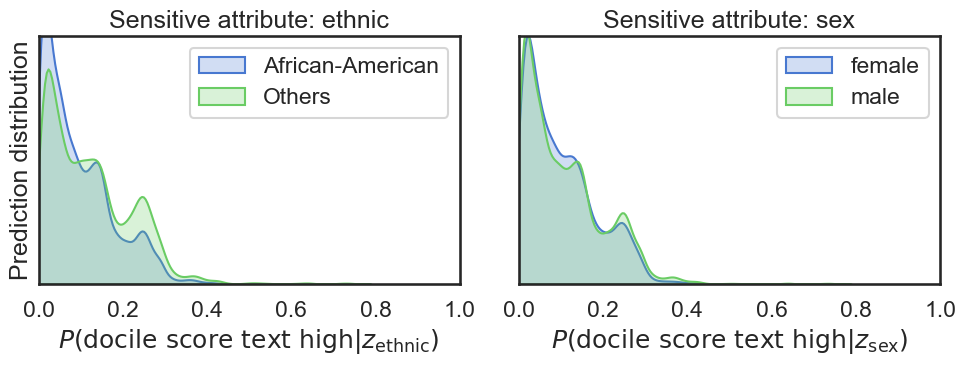

In [140]:
def plot_distributions(y, Z, iteration=None, val_metrics=None, p_rules=None, fname=None):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    legend={'ethnic': ['African-American','Others'],
            'sex': ['female','male']}
    
    for idx, attr in enumerate(Z.columns):
        for attr_val in [0, 1]:
            ax = sns.kdeplot(data=y[Z[attr] == attr_val],
                             label='{}'.format(legend[attr][attr_val]), 
                             ax=axes[idx], fill=True)
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 7)
            ax.set_yticks([])
            ax.set_xlabel(r'$P(\mathrm{{docile\ score\ text\ high}}|z_{{\mathrm{{{}}}}})$'.format(attr))
            ax.set_title("Sensitive attribute: {}".format(attr))
            if idx == 0:
                ax.set_ylabel('Prediction distribution')

    axes[0].legend()
    axes[1].legend()
    
    if iteration:
        fig.text(1.0, 0.9, f"Training iteration #{iteration}", fontsize='16')
    if val_metrics is not None:
        fig.text(1.0, 0.65, '\n'.join(["Prediction performance:",
                                       f"- ROC AUC: {val_metrics['ROC AUC']:.2f}",
                                       f"- Accuracy: {val_metrics['Accuracy']:.1f}"]),
                 fontsize='16')
    if p_rules is not None:
        fig.text(1.0, 0.4, '\n'.join(["Satisfied p%-rules:"] +
                                     [f"- {attr}: {p_rules[attr]:.0f}%-rule" 
                                      for attr in p_rules.keys()]), 
                 fontsize='16')
    fig.tight_layout()
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight', dpi=300)

    return fig, legend

    
fig, legend= plot_distributions(y_pred, Z_test, fname='images/biased_training.png')

shows that other ethnic have a higher chance of getting a docile score of high and males have a slightly higher chance of getting high docile score.

## Quantitative model fairness


In [141]:
def p_rule(y_pred, z_values, threshold=0.5):
    y_z_1 = y_pred[z_values == 1] > threshold if threshold else y_pred[z_values == 1]
    y_z_0 = y_pred[z_values == 0] > threshold if threshold else y_pred[z_values == 0]
    odds = y_z_1.mean() / y_z_0.mean()
    return np.min([odds, 1/odds]) * 100

print("The classifier satisfies the following %p-rules:")
print(f"\tgiven attribute race; {p_rule(y_pred, Z_test['ethnic']):.0f}%-rule")
print(f"\tgiven attribute sex;  {p_rule(y_pred, Z_test['sex']):.0f}%-rule")

The classifier satisfies the following %p-rules:
	given attribute race; 26%-rule
	given attribute sex;  52%-rule


We find that for both sensitive attributes the classifier satisfies a p%-rule that is significantly lower than 80%. This supports our earlier conclusion that the trained classifier is unfair in making its predictions.

## Fighting bias with Adversarial Debiasing 

In [172]:
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
from keras.metrics import BinaryAccuracy
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from sklearn.metrics import roc_auc_score, accuracy_score
import numpy as np

# Define the Adversarial Debiasing Model
def adversarial_debiasing(n_features, n_sensitive, hidden_units=32, dropout_rate=0.25):
    # Classifier
    inputs = Input(shape=(n_features,))
    dense1 = Dense(hidden_units, activation='relu')(inputs)
    dropout1 = Dropout(dropout_rate)(dense1)
    dense2 = Dense(hidden_units, activation='relu')(dropout1)
    dropout2 = Dropout(dropout_rate)(dense2)
    outputs = Dense(1, activation='sigmoid', name='classifier_output')(dropout2)

    # Adversary
    adversary_output = Dense(n_sensitive, activation='sigmoid', name='adversary_output')(dropout2)

    model = Model(inputs=[inputs], outputs=[outputs, adversary_output])
    return model

# Define Loss Functions
def classifier_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred)

def adversary_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred)

# Train the Model
def train_adversarial_debiasing(X_train, y_train, Z_train, epochs=20):
    # Get number of features and sensitive attributes
    n_features = X_train.shape[1]
    n_sensitive = Z_train.shape[1]
    
    # Initialize the model
    model = adversarial_debiasing(n_features, n_sensitive)
    
    # Compile the model
    model.compile(optimizer=Adam(),
                  loss={'classifier_output': classifier_loss, 'adversary_output': adversary_loss},
                  metrics={'classifier_output': BinaryAccuracy()})
    
    # Train the model
    model.fit(X_train, {'classifier_output': y_train, 'adversary_output': Z_train},
              epochs=epochs, verbose=1)
    
    return model

# Train the Adversarial Debiasing Model
adversarial_debiasing_model = train_adversarial_debiasing(X_train.values, y_train.values, Z_train.values)

# Evaluate the Model
y_pred_classifier, y_pred_adversary = adversarial_debiasing_model.predict(X_test.values)
y_pred_classifier = (y_pred_classifier > 0.5).astype(int)
y_pred_adversary = (y_pred_adversary > 0.5).astype(int)

roc_auc_classifier = roc_auc_score(y_test, y_pred_classifier)
accuracy_classifier = accuracy_score(y_test, y_pred_classifier)

print(f"Classifier ROC AUC: {roc_auc_classifier}")
print(f"Classifier Accuracy: {accuracy_classifier}")

# Compute the % p-rules for both sensitive attributes
def p_rule(y_pred, z_values, threshold=0.5):
    y_z_1 = y_pred[z_values == 1] > threshold if threshold else y_pred[z_values == 1]
    y_z_0 = y_pred[z_values == 0] > threshold if threshold else y_pred[z_values == 0]
    odds = y_z_1.mean() / y_z_0.mean()
    return np.min([odds, 1/odds]) * 100

p_rule_race = p_rule(y_pred_classifier, Z_test['ethnic'])
p_rule_sex = p_rule(y_pred_classifier, Z_test['sex'])

print("The classifier satisfies the following %p-rules:")
print(f"\tGiven attribute ethnic: {p_rule_race:.2f}%")
print(f"\tGiven attribute sex: {p_rule_sex:.2f}%")


Epoch 1/20
950/950 [==============================] - 2s 1ms/step - loss: 0.9692 - classifier_output_loss: 0.3579 - adversary_output_loss: 0.6114 - classifier_output_binary_accuracy: 0.8852
Epoch 2/20
950/950 [==============================] - 1s 1ms/step - loss: 0.9164 - classifier_output_loss: 0.3250 - adversary_output_loss: 0.5913 - classifier_output_binary_accuracy: 0.8876
Epoch 3/20
950/950 [==============================] - 1s 1ms/step - loss: 0.9026 - classifier_output_loss: 0.3158 - adversary_output_loss: 0.5868 - classifier_output_binary_accuracy: 0.8881
Epoch 4/20
950/950 [==============================] - 1s 1ms/step - loss: 0.8992 - classifier_output_loss: 0.3133 - adversary_output_loss: 0.5859 - classifier_output_binary_accuracy: 0.8874
Epoch 5/20
950/950 [==============================] - 1s 1ms/step - loss: 0.8939 - classifier_output_loss: 0.3101 - adversary_output_loss: 0.5838 - classifier_output_binary_accuracy: 0.8877
Epoch 6/20
950/950 [==============================